In [1]:
global_update_live = True
email_both = False

In [2]:
import pandas as pd
import random
from pydataquery import DataQuery
from matplotlib.colors import LinearSegmentedColormap
from xbbg import blp
import numpy as np
import pytz
import time
from datetime import datetime, timedelta
import statsmodels.api as sm
from ipywidgets import interact, Dropdown, HBox, VBox, Button, Output, Text, widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import re
import scipy.stats as stats
from adjustText import adjust_text
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sympy as sp
import itertools
import warnings
import openpyxl
import subprocess
import dataframe_image as dfi
import time
import pyautogui
import pygetwindow as gw
import pyodbc
import ast
import json
warnings.filterwarnings("ignore")

In [3]:
with open('Rating_Dict.json', 'r') as f:
    f_dict = json.load(f)

df5a = pd.read_parquet("Basis df5a.parquet")

In [4]:
dt_list = [item.replace("Mat_Matched_CDS_","") for item in df5a.columns if item.startswith("Mat_Matched_CDS")]
last_update = str(max(pd.to_datetime(dt_list)).date())

df5 = df5a.drop([col for col in df5a.columns if "UF100" in col or "UF500" in col], axis=1).copy()
df5 = df5[["ISIN","CUSIP","Name","Maturity","Issuer Equity_red_tier_ccy_docclause"] +\
    [col for col in df5.columns if last_update in col or col.startswith("Basis_")]].copy()

In [5]:
####################################### Zscore and 1Y High/Low Calc

dfz = df5[["ISIN"] + [item for item in df5.columns if "Basis" in item]]
dfz = dfz.set_index("ISIN").T
dfz.index = [pd.to_datetime(item.split("_")[1]).date() for item in dfz.index]
dfz = dfz.sort_index()

all_z_df = None
for period in [3*22, 6*22, 12*22]:
    x = ((dfz-dfz.rolling(period, min_periods = int(0.6*period)).mean())/dfz.rolling(period,\
                  min_periods = int(0.6*period)).std()).iloc[[-1],:].copy()
    x.index = [f'ZScore_{int(period/22)}M']
    all_z_df = pd.concat([all_z_df , x])

max_1y = pd.DataFrame(dfz.iloc[-12*22:,:].max()).T
max_1y.index = [f'Basis 1Y High']
min_1y = pd.DataFrame(dfz.iloc[-12*22:,:].min()).T
min_1y.index = [f'Basis 1Y Low']

all_z_df = pd.concat([all_z_df , max_1y, min_1y])
all_z_df = all_z_df.T
all_z_df = all_z_df.reset_index()

df6 = pd.merge(left=df5.drop([col for col in df5.columns if col.\
    startswith("Basis_") and not last_update in col],axis=1),\
               right=all_z_df, on="ISIN", how="inner").drop(["CUSIP","Maturity"],axis=1).copy()

In [6]:
try:
    df7 = df6.drop(f"Dur_{last_update}",axis=1).copy()
except:
    df7 = df6.copy()
df7["Family"] = df7["Issuer Equity_red_tier_ccy_docclause"].apply(lambda x: f_dict[x])
df7["CDS RED Code"] =  df7["Issuer Equity_red_tier_ccy_docclause"].apply(lambda x: x.split("_")[1])
df7.columns = df7.columns.str.replace(f"_{last_update}","").str.replace("Mat_Matched_CDS","Mat. Matched CDS")
df7["First Sort"] = df7["Name"].apply(lambda x: x.split(" ")[0])
df7["Second Sort"] = df7["Name"].apply(lambda x: x.rsplit("/")[-1])

df7 = df7.sort_values(by=["First Sort","Second Sort"],ascending=[True, True])
df7 = df7.drop(["ISIN","Issuer Equity_red_tier_ccy_docclause","First Sort","Second Sort"], axis=1).set_index("Name").copy()

df7 = df7[["Family","CDS RED Code","Price","Sprd","Mat. Matched CDS","Basis","Basis 1Y Low","Basis 1Y High",\
           "ZScore_3M","ZScore_6M","ZScore_12M"]].copy()
df7 = round(df7,2)

In [7]:
for family in ["HY","IG","EUR_HY", 'EUR_IG', 'SNRFIN', 'SUBFIN']:
    df8 = df7[df7["Family"]==family].copy()
    df8["Issuer"] = [item.split(" ")[0] for item in df8.index]
    issuers = df8["Issuer"].to_list()
    all_corp_z = pd.DataFrame(columns={"Family":[],"Basis 3M ZScore":[],"Basis 6M ZScore":[],"Basis 12M ZScore":[]})
    for issuer in issuers:
        all_corp_z.loc[issuer] = list(set(df8[df8["Issuer"] == issuer]["Family"])) +\
        list(df8[df8["Issuer"] == issuer][["ZScore_3M","ZScore_6M","ZScore_12M"]].median(axis=0))
    all_corp_z = round(all_corp_z.drop("Family",axis=1),1)
    globals()[f'df_{family}'] = all_corp_z.copy()

In [8]:
def color_negative_red_positive_green_basis(col: pd.Series):
    if col.empty:
        return ['' for _ in col]
    float_col = col[col.apply(lambda x: isinstance(x, float))]
    min_val, max_val = float_col.min(), float_col.max()
    def value_to_color(val):
        if not isinstance(val, float):
            return ''
        if val < 0 and min_val < 0:
            frac = val/ min_val
            frac = max(min(frac,1),0)
            r = int(255 - (255 - 87) * frac)
            g = int(255 - (255 - 187) * frac)
            b = int(255 - (255 - 138) * frac)
            a = 0.75
            return f'background-color: rgb({r},{g},{b},{a})'
        elif val > 0 and max_val > 0:
            frac = val/ max_val
            frac = max(min(frac,1),0)
            r = int(255 - (255 - 230) * frac)
            g = int(255 - (255 - 135) * frac)
            b = int(255 - (255 - 115) * frac)
            a = 0.75
            return f'background-color: rgb({r},{g},{b},{a})'
        return ''
    return [value_to_color(v) for v in col]

def add_vertical_lines(df):
    styles = pd.DataFrame('', index=df.index, columns=df.columns)
    for i in range(1, len(df.columns), 2):
        styles.iloc[:, i] = 'border-right: 8px solid black;'
    return styles
    
def style_rich_cheap_basis(df):
    styled_df = df.style.apply(color_negative_red_positive_green_basis, subset=df.columns[-3:], axis=0)
    styled_df = styled_df.format(precision=2)
    styled_df = styled_df.format(precision=0, subset=df.columns[2:7])
    styled_df = styled_df.format(precision=1, subset=df.columns[-3:])
    styled_df = styled_df.set_properties(**{'text-align': 'center'})
    styled_df = styled_df.applymap(lambda val: 'font-weight: bold', subset=pd.IndexSlice[:, df.columns[4]])
    return styled_df
    
for rating_col in ["IG","HY","EUR_IG","EUR_HY","SNRFIN","SUBFIN"]:
    df1 = df7[df7["Family"]==rating_col].drop("Family",axis=1)
    df1["Issuer"] = [item.split(" ")[0] for item in df1.index]
    
    num_issuers = len(set([item.split(" ")[0] for item in df1.index]))
    
    issuers_per_table = 4
    # issuers_list = list(sorted(set([item.split(" ")[0] for item in df1.index])))
    issuers_list = list(sorted(set(df1["Issuer"])))
    
    for i in range(int(num_issuers/issuers_per_table)+1):
        globals()[f'df_{i}'] = df1[df1["Issuer"].isin(issuers_list[issuers_per_table*i:issuers_per_table*i+issuers_per_table])].copy()
    
    modified_dfs = []
    
    for i in range(int(num_issuers / issuers_per_table) + 1):
        df = globals()[f'df_{i}'].reset_index().copy()
        new_df = pd.DataFrame(columns=df.columns)
        
        for issuer in df['Issuer'].unique():
            issuer_rows = df[df['Issuer'] == issuer]
            new_df = pd.concat([new_df, issuer_rows], ignore_index=True)
            empty_row = pd.Series([''] * len(df.columns), index=df.columns)
            new_df = pd.concat([new_df, pd.DataFrame([empty_row])], ignore_index=True)
        globals()[f'df_{i}'] = new_df.set_index(new_df.columns[0]).drop("Issuer",axis=1).copy()                
    
        
    for i in range(int(num_issuers / issuers_per_table) + 1):
        df = globals()[f'df_{i}'].copy()
        index_counts = {}
        new_index = []
        
        for idx in df.index:
            if idx in index_counts:
                index_counts[idx] += 1
                # new_index.append(f"{idx}_{index_counts[idx]}")
                new_index.append(f"{idx}{'_' * index_counts[idx]}{pd.to_datetime(last_update).strftime("%d-%b")}")
    
            else:
                count = df.index.tolist().count(idx)
                if count > 1:
                    index_counts[idx] = 1
                    new_index.append(f"{idx}_{pd.to_datetime(last_update).strftime("%d-%b")}")
                else:
                    new_index.append(idx)
        df.index = new_index
        df.index.name = f'{pd.to_datetime(last_update).strftime("%d-%b")}'
        globals()[f'display_df_{i}'] = style_rich_cheap_basis(df.iloc[:-1,:])
        globals()[f'display_df_{i}'] = globals()[f'display_df_{i}'].set_table_styles(
            [
                {'selector': 'tr', 'props': [('width', '8px')]},
                {'selector': 'th, td', 'props': [('line-height', '8px')]}
            ],)
    
        dfi.export(globals()[f'display_df_{i}'] , f'Plots/{rating_col}/{rating_col}_{i}.png', table_conversion='chrome', dpi=100)
    
    import os
    import win32com.client
    import glob
    import pandas as pd
    import dataframe_image as dfi
    from io import BytesIO
    import tempfile
    
    html_body = "<html><body>"
    
    outlook = win32com.client.Dispatch("Outlook.Application")
    mail = outlook.CreateItem(0)
    
    folder_path = f'J:\\53A. HY Bonds Basis Email\\Plots\\{rating_col}'
    png_files = glob.glob(os.path.join(folder_path, '*.png'))
    png_files = [item for item in png_files if f"{rating_col}_" in item]
    png_files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].rsplit("_")[-1]))
    
    for png_file in png_files:
        raw_name = os.path.splitext(os.path.basename(png_file))[0]
        image_cid = raw_name.replace(" ", "_")
        attachment = mail.Attachments.Add(Source=png_file)
        attachment.PropertyAccessor.SetProperty("http://schemas.microsoft.com/mapi/proptag/0x3712001F", image_cid)
        html_body += f'<img src="cid:{image_cid}"><br><br><br>'
    
    html_body += '</body></html>'
    
    mail.HTMLBody = html_body
    mail.Subject = f'{rating_col.replace("_"," ")} Basis (auto)'
    mail.CC = 'vasu.sharma@iiicm.com'
    if email_both:
        mail.To = 'spyros.michas@iiicm.com'
    mail.Send()
    
print("Sent")


Sent


In [9]:
def style_rich_cheap_basis(df):
    # styled_df = df.style.applymap(color_negative_red_positive_green_basis, subset=df.columns[-3:])
    styled_df = df.style.apply(color_negative_red_positive_green_basis, subset=df.columns[:], axis=0)
    # styled_df = styled_df.format(precision=2)
    # styled_df = styled_df.format(precision=0, subset=df.columns[1:6])
    styled_df = styled_df.format(precision=1, subset=df.columns[:])
    styled_df = styled_df.set_properties(**{'text-align': 'center'})
    # styled_df = styled_df.applymap(lambda val: 'font-weight: bold', subset=pd.IndexSlice[:, df.columns[3]])
    return styled_df
    
    
# em = pd.read_excel(
#     r"J:\\8A. Automating EM & EMB vs IEF SR+PnL Optimization\\DQ_Data_v75.xlsx",\
#                    index_col=0, parse_dates=True)

em = pd.read_excel("DQ_Data_v75.xlsx",index_col=0, parse_dates=True)

dfz = em[[col for col in em.columns if col.endswith("Basis")]].dropna(how="all").copy()
all_z_df = None

for period in [63, 126, 252]:
    nan_limit = 0.95 if period==252 else 0.9
    x = ((dfz-dfz.rolling(period, min_periods = int(nan_limit*period)).mean())/dfz.rolling(period,\
                  min_periods = int(nan_limit*period)).std()).iloc[[-1],:].copy()
    x.index = [f'ZScore_{int(period/21)}M']
    all_z_df = pd.concat([all_z_df , x])

all_z_df = all_z_df.T
all_z_df["Country"] = [item.split(" ")[0] for item in all_z_df.index]

all_z_df["Year"] = [item.rsplit(" ",2)[-2] for item in all_z_df.index]
all_z_df = round(all_z_df.sort_values(by=["Country","Year"],ascending=True),1)

em_scores = pd.DataFrame(columns={"Basis 3M ZScore":[],"Basis 6M ZScore":[],"Basis 12M ZScore":[]})
for issuer in sorted(list(set(all_z_df["Country"]))):
    # issuer = list(set(all_z_df["Country"]))[0]
    em_scores.loc[issuer] =\
    list(all_z_df[all_z_df["Country"]==issuer][["ZScore_3M","ZScore_6M","ZScore_12M"]].median(axis=0))
df_EM = round(em_scores,1).copy()

In [10]:
for family in ["EM","HY","IG","EUR_HY", 'EUR_IG', 'SNRFIN', 'SUBFIN']:
    num = int(len(globals()[f'df_{family}'])/26)+1
    
    for i in range(num):
        display_df1 = globals()[f'df_{family}'].iloc[30*i:30*i+30].copy()
        display_df1 = style_rich_cheap_basis(display_df1)
        display_df1.index.name = f'{em.index[-1].strftime("%d-%b") if family=="EM" else pd.\
            to_datetime(last_update).strftime("%d-%b")}'
        
        display_df1 = display_df1.set_table_styles(
            [{'selector': 'tr', 'props': [('width', '8px')]},
                {'selector': 'th, td', 'props': [('line-height', '8px')]}],)
        dfi.export(display_df1, f'Email Plots/{family.replace("_","")}_{i+1}.png', table_conversion='chrome', dpi=100)

In [11]:
plot_names = None
for family in ["EM","HY","IG","EUR_HY", 'EUR_IG', 'SNRFIN', 'SUBFIN']:
    df = globals()[f'df_{family}'].copy()
    df = df[(abs(df["Basis 3M ZScore"])>=1.5) & (abs(df["Basis 6M ZScore"])>=1.5) & (abs(df["Basis 12M ZScore"])>=1.5)]
    df["Family"] = [family] * len(df)
    plot_names = pd.concat([plot_names,df])

In [12]:
# ############## Setting Default Bonds
# isin_list = [
#              "US105756BZ27", "US105756CA66", "US105756CC23", "US105756CG37", "US105756CE88", "US105756CK49", "US105756CF53", "US105756CH10", "US105756BW95", "US105756BY51", "US105756CB40", "US105756CJ75", "US168863DX33", "US168863CF36", "US168863EB04", "US168863DP09", "US168863DN50", "US168863DT21", "US168863DV76", "US168863DZ80", "US168863DS48", "US168863DY16", "US168863CE60", "US168863DL94", "US168863DW59", "XS2327851874", "US168863EA21", "US168863DQ81", "US168863DU93", "US195325DL65", "US195325DP79", "US195325DR36", "US195325DS19", "US195325DZ51", "US195325EF88", "US195325EG61", "US195325EL56", "US195325BK01", "US195325BM66", "US195325EA91", "US195325BR53", "US195325CU73", "US195325DQ52", "US195325DT91", "US195325EM30", "US195325DX04", "US91087BAC46", "US91087BAE02", "US91087BAU44", "US91087BAF76", "US91087BAY65", "US91087BAH33", "US91087BAM28", "US91087BAK61", "US91087BAT70", "US91087BAR15", "US91087BAV27", "US91087BAZ31", "US91086QAV05", "US91087BAQ32", "US91086QBB32", "US91086QBE70", "US91086QBF46", "US91087BAB62", "US91087BAD29", "US91087BAG59", "US91087BAL45", "US91087BAS97", "US91087BAX82", "US91087BBA70", "US91087BAN01", "XS2280637039", "US91086QAZ19", "US698299BF03", "US698299BK97", "US698299BX19", "USP90603AP97", "US698299BN37", "US698299BR41", "US698299BT07", "US698299AW45", "US698299BW36", "US698299BY91", "US698299BG85", "US698299BH68", "US698299BB98", "US698299BV52", "US698299BM53", "US698299BL70", "US698299BS24", "US715638BU55", "US715638DA73", "US715638DF60", "US715638DP43", "US715638DU38", "US715638EB48", "US715638DS81", "US715638BM30", "US715638DT64", "US715638EC21", "US715638DQ26", "US715638DW93", "US715638DR09", "US836205AW44", "US836205AU87", "US836205BA15", "US836205AY00", "US836205BC70", "US836205AS32", "US836205AV60", "US836205AX27", "US836205BB97", "US836205BE37", "US900123CL22", "USM88269US88", "US900123DF45", "US900123CP36", "US900123CQ19", "US900123DH01", "US900123CT57", "US900123CY43", "US900123DJ66", "US900123DA57", "US900123DC14", "US900123DL13", "US900123DG28", "US900123DD96", "US900123AT75", "US900123DK30", "US900123DN78", "US900123AY60", "US900123BB58", "US900123BG46", "US900123BJ84", "US900123CB40", "US900123CG37", "US900123CM05", "USP3579EBV85", "USP3579ECB13", "USP3579ECP09", "USP3579ECF27", "USP3579ECR64", "USP3579ECH82", "USP3579ECN50", "USP3579ECU93", "USP3579ECJ49", "USP3579EAY34", "USP3579EBE60", "USP3579EBY25", "USP3579ECE51", "USP3579ECG00", "US71654QDB59", "US71654QCG55", "US71654QCK67", "US71654QCP54", "US71654QDL32", "US71654QDC33", "US71654QDE98", "US71643VAB18", "US71654QDP46", "US706451BG56", "US71654QAZ54", "US71654QBR20", "US71654QCC42", "US71654QCL41", "US71654QDD16", "US71654QDF63", "US71656MAF68", "US71647NAS80", "US71647NAY58", "US71647NBH17", "US71647NBK46", "US71647NBL29", "US71645WAQ42", "US71645WAS08", "US71647NAK54", "US71647NBJ72", "US71647NAN93",
#              "XS2214237807", "XS2214239506", "XS2214238441", "XS2214239175", "US040114HX11", "US040114HS26", "US040114HT09", "US040114HU71", "US040114HV54", "US040114HW38", "XS1910826996", "XS1717011982", "XS2384698994", "XS2445169985", "XS1777972511", "XS1910827887", "XS2948511949", "XS1566179039", "XS2384701020", "XS2948512913", "XS1777972941", "XS1717013095", "XS1910828182", "XS2384704800", "XS1843435840", "XS1781710543", "XS2764839945", "XS1843435766", "XS2354781614", "XS1781710626", "XS1318576086", "XS1819680288", "XS2083302419", "XS2446175577", "XS1819680528", "XS2083302500", "XS1790104530", "XS1619155564", "XS2333676133", "XS1790134362", "XS2297220423", "XS1903488572", "XS1558078736", "XS2391394348", "XS1775618439", "XS1504948776", "XS1953057061", "XS1903489463", "XS2297226545", "XS2079842642", "XS2176897754", "XS2391395154", "XS1558078496", "XS1775617464", "XS1953057491", "XS2176899701", "XS2391398174", "USP01012BX31", "USP01012CF16", "XS0146173371", "USP01012AN67", "USP01012AR71", "USP01012CA29", "USP01012CC84", "USP01012CH71", 
#              "USP7808BAA54", "USP7808BAB38", "XS0505478684", "XS2079846635", "XS2297221405",
#              "USG2583XAB76", "USL21779AL44", "USL21779AJ97", "USL21779AK60", 
#             ]

# isin_list += ['XS2965710598','US105756CM05','US105756CL22','US168863EE43','US195325EQ44','US195325ER27','US195325ES00','US195325EP60','USP3579ECW59','USP3579ECX33','US03846JAH32','US03846JAG58','XS3010561762','US91087BBB53','US91087BBD10','US91087BBF67','US91087BBE92','US91087BBC37','US715638FD94','US715638FC12','XS2908172260','US836205BG84','US900123DQ00','USN15516AJ10']

# names_list = [
#              "BRAZIL 4 5/8 01/13/28", "BRAZIL 4 1/2 05/30/29", "BRAZIL 3 7/8 06/12/30", "BRAZIL 6 1/4 03/18/31", "BRAZIL 3 3/4 09/12/31", "BRAZIL 6 1/8 01/22/32", "BRAZIL 6 10/20/33", "BRAZIL 6 1/8 03/15/34", "BRAZIL 5 01/27/45", "BRAZIL 5 5/8 02/21/47", "BRAZIL 4 3/4 01/14/50", "BRAZIL 7 1/8 05/13/54", "CHILE 2 3/4 01/31/27", "CHILE 3.24 02/06/28", "CHILE 4.85 01/22/29", "CHILE 2.45 01/31/31", "CHILE 2.55 01/27/32", "CHILE 2.55 07/27/33", "CHILE 3 1/2 01/31/34", "CHILE 4.95 01/05/36", "CHILE 3.1 05/07/41", "CHILE 4.34 03/07/42", "CHILE 3.86 06/21/47", "CHILE 3 1/2 01/25/50", "CHILE 4 01/31/52", "CHILE 3 1/2 04/15/53", "CHILE 5.33 01/05/54", "CHILE 3.1 01/22/61", "CHILE 3 1/4 09/21/2071", "COLOM 3 7/8 04/25/27", "COLOM 4 1/2 03/15/29", "COLOM 3 01/30/30", "COLOM 3 1/8 04/15/31", "COLOM 3 1/4 04/22/32", "COLOM 8 04/20/33", "COLOM 7 1/2 02/02/34", "COLOM 8 11/14/35", "COLOM 7 3/8 09/18/37", "COLOM 6 1/8 01/18/41", "COLOM 4 1/8 02/22/42", "COLOM 5 5/8 02/26/44", "COLOM 5 06/15/45", "COLOM 5.2 05/15/49", "COLOM 4 1/8 05/15/51", "COLOM 8 3/4 11/14/53", "COLOM 3 7/8 02/15/61", "MEX 4.15 03/28/27", "MEX 3 3/4 01/11/28", "MEX 5.4 02/09/28", "MEX 4 1/2 04/22/29", "MEX 5 05/07/29", "MEX 3 1/4 04/16/30", "MEX 2.659 05/24/31", "MEX 4 3/4 04/27/32", "MEX 4 7/8 05/19/33", "MEX 3 1/2 02/12/34", "MEX 6.35 02/09/35", "MEX 6 05/07/36", "MEX 6.05 01/11/40", "MEX 4.28 08/14/41", "MEX 4 3/4 03/08/44", "MEX 5.55 01/21/45", "MEX 4.6 01/23/46", "MEX 4.35 01/15/47", "MEX 4.6 02/10/48", "MEX 4 1/2 01/31/50", "MEX 5 04/27/51", "MEX 4.4 02/12/52", "MEX 6.338 05/04/53", "MEX 6.4 05/07/54", "MEX 3.771 05/24/61", "MEX 3 3/4 04/19/2071", "MEX 5 3/4 10/12/2110", "PANAMA 3 7/8 03/17/28", "PANAMA 3.16 01/23/30", "PANAMA 7 1/2 03/01/31", "PANAMA 3.362 06/30/31", "PANAMA 2.252 09/29/32", "PANAMA 3.298 01/19/33", "PANAMA 6.4 02/14/35", "PANAMA 6.7 01/26/36", "PANAMA 6 7/8 01/31/36", "PANAMA 8 03/01/38", "PANAMA 4 1/2 05/15/47", "PANAMA 4 1/2 04/16/50", "PANAMA 4.3 04/29/53", "PANAMA 6.853 03/28/54", "PANAMA 4 1/2 04/01/56", "PANAMA 3.87 07/23/60", "PANAMA 4 1/2 01/19/63", "PERU 4 1/8 08/25/27", "PERU 2.844 06/20/30", "PERU 2.783 01/23/31", "PERU 1.862 12/01/32", "PERU 3 01/15/34", "PERU 5 3/8 02/08/35", "PERU 3.3 03/11/41", "PERU 5 5/8 11/18/50", "PERU 3.55 03/10/51", "PERU 5 7/8 08/08/54", "PERU 2.78 12/01/60", "PERU 3.6 01/15/2072", "PERU 3.23 07/28/2121", "SOAF 4.85 09/27/27", "SOAF 4.3 10/12/28", "SOAF 4.85 09/30/29", "SOAF 5 7/8 06/22/30", "SOAF 5 7/8 04/20/32", "SOAF 5 3/8 07/24/44", "SOAF 5 10/12/46", "SOAF 5.65 09/27/47", "SOAF 5 3/4 09/30/49", "SOAF 7.3 04/20/52", "TURKEY 6 03/25/27", "TURKEY 8.6 09/24/27", "TURKEY 9 7/8 01/15/28", "TURKEY 5 1/8 02/17/28", "TURKEY 6 1/8 10/24/28", "TURKEY 9 3/8 03/14/29", "TURKEY 7 5/8 04/26/29", "TURKEY 5 1/4 03/13/30", "TURKEY 9 1/8 07/13/30", "TURKEY 5.95 01/15/31", "TURKEY 5 7/8 06/26/31", "TURKEY 7 1/8 07/17/32", "TURKEY 9 3/8 01/19/33", "TURKEY 6 1/2 09/20/33", "TURKEY 8 02/14/34", "TURKEY 7 5/8 05/15/34", "TURKEY 6 1/2 01/03/35", "TURKEY 6 7/8 03/17/36", "TURKEY 7 1/4 03/05/38", "TURKEY 6 3/4 05/30/40", "TURKEY 6 01/14/41", "TURKEY 4 7/8 04/16/43", "TURKEY 6 5/8 02/17/45", "TURKEY 5 3/4 05/11/47", "DOMREP 5.95 01/25/27", "DOMREP 6 07/19/28", "DOMREP 5 1/2 02/22/29", "DOMREP 4 1/2 01/30/30", "DOMREP 7.05 02/03/31", "DOMREP 4 7/8 09/23/32", "DOMREP 6 02/22/33", "DOMREP 6.6 06/01/36", "DOMREP 5.3 01/21/41", "DOMREP 7.45 04/30/44", "DOMREP 6.85 01/27/45", "DOMREP 6 1/2 02/15/48", "DOMREP 6.4 06/05/49", "DOMREP 5 7/8 01/30/60", "PEMEX 6.49 01/23/27", "PEMEX 6 1/2 03/13/27", "PEMEX 5.35 02/12/28", "PEMEX 6 1/2 01/23/29", "PEMEX 8 3/4 06/02/29", "PEMEX 6.84 01/23/30", "PEMEX 5.95 01/28/31", "PEMEX 6.7 02/16/32", "PEMEX 10 02/07/33", "PEMEX 6 5/8 06/15/35", "PEMEX 6 1/2 06/02/41", "PEMEX 6 3/8 01/23/45", "PEMEX 6 3/4 09/21/47", "PEMEX 6.35 02/12/48", "PEMEX 7.69 01/23/50", "PEMEX 6.95 01/28/60", "PEMEX 6 5/8 PERP", "PETBRA 7 3/8 01/17/27", "PETBRA 5.999 01/27/28", "PETBRA 5.6 01/03/31", "PETBRA 6 1/2 07/03/33", "PETBRA 6 01/13/35", "PETBRA 6 7/8 01/20/40", "PETBRA 6 3/4 01/27/41", "PETBRA 7 1/4 03/17/44", "PETBRA 5 1/2 06/10/51", "PETBRA 6.85 06/05/2115",
#              "ECUA 6.9 07/31/30", "ECUA 0 07/31/30", "ECUA 5 1/2 07/31/35", "ECUA 5 07/31/40", "ARGENT 1 07/09/29", "ARGENT 0 3/4 07/09/30", "ARGENT 4 1/8 07/09/35", "ARGENT 5 01/09/38", "ARGENT 3 1/2 07/09/41", "ARGENT 4 1/8 07/09/46", "NGERIA 7 5/8 11/21/25", "NGERIA 6 1/2 11/28/27", "NGERIA 6 1/8 09/28/28", "NGERIA 8 3/8 03/24/29", "NGERIA 7.143 02/23/30", "NGERIA 8.747 01/21/31", "NGERIA 9 5/8 06/09/31", "NGERIA 7 7/8 02/16/32", "NGERIA 7 3/8 09/28/33", "NGERIA 10 3/8 12/09/34", "NGERIA 7.696 02/23/38", "NGERIA 7 5/8 11/28/47", "NGERIA 9.248 01/21/49", "NGERIA 8 1/4 09/28/51", "KENINT 7 05/22/27", "KENINT 7 1/4 02/28/28", "KENINT 9 3/4 02/16/31", "KENINT 8 05/22/32", "KENINT 6.3 01/23/34", "KENINT 8 1/4 02/28/48", "ANGOL 9 1/2 11/12/25", "ANGOL 8 1/4 05/09/28", "ANGOL 8 11/26/29", "ANGOL 8 3/4 04/14/32", "ANGOL 9 3/8 05/08/48", "ANGOL 9 1/8 11/26/49", "SENEGL 4 3/4 03/13/28", "SENEGL 6 1/4 05/23/33", "SENEGL 5 3/8 06/08/37", "SENEGL 6 3/4 03/13/48", "EGYPT 3 7/8 02/16/26", "EGYPT 7 1/8 11/10/26", "EGYPT 7 1/2 01/31/27", "EGYPT 5.8 09/30/27", "EGYPT 6.588 02/21/28", "EGYPT 7 11/10/28", "EGYPT 7.6003 03/01/29", "EGYPT 7 5/8 11/10/30", "EGYPT 5 7/8 02/16/31", "EGYPT 7.0529 01/15/32", "EGYPT 7 5/8 05/29/32", "EGYPT 7.3 09/30/33", "EGYPT 8 1/2 01/31/47", "EGYPT 7.903 02/21/48", "EGYPT 8.7002 03/01/49", "EGYPT 8 7/8 05/29/50", "EGYPT 8 3/4 09/30/51", "ELSALV 8 5/8 02/28/29", "ELSALV 9 1/4 04/17/30", "ELSALV 8 1/4 04/10/32", "ELSALV 7.65 06/15/35", "ELSALV 7 5/8 02/01/41", "ELSALV 7.1246 01/20/50", "ELSALV 9 1/2 07/15/52", "ELSALV 9.65 11/21/54", 
#              "PETRPE 4 3/4 06/19/32", "PETRPE 5 5/8 06/19/47", "EGYPT 6 7/8 04/30/40", "EGYPT 8.15 11/20/59", "EGYPT 7 1/2 02/16/61", 
#              "CSNABZ 6 3/4 01/28/28", "CSNABZ 8 7/8 12/05/30", "CSNABZ 4 5/8 06/10/31", "CSNABZ 5 7/8 04/08/32",
#              ]
# names_list += ['ANGOL 10.95 12/27/30', 'BRAZIL 5 1/2 11/06/30', 'BRAZIL 6 5/8 03/15/35', 'CHILE 5.65 01/13/37', 'COLOM 8 3/8 11/07/54', 'COLOM 7 3/8 04/25/30', 'COLOM 8 1/2 04/25/35', 'COLOM 7 3/4 11/07/36', 'DOMREP 6.95 03/15/37', 'DOMREP 7.15 02/24/55', 'EGYPT 8 5/8 02/04/30', 'EGYPT 9.45 02/04/33', 'KENINT 9 1/2 03/05/36', 'MEX 6 05/13/30', 'MEX 7 3/8 05/13/55', 'MEX 6 5/8 01/29/38', 'MEX 5.85 07/02/32', 'MEX 6 7/8 05/13/37', 'PERU 6.2 06/30/55', 'PERU 5 1/2 03/30/36', 'SOAF 7.1 11/19/36', 'SOAF 7.95 11/19/54', 'TURKEY 7 1/4 05/29/32', 'BRASKM 8 10/15/34']
# names_list[names_list.index("PEMEX 6 5/8 PERP")] = "PEMEX 6 5/8 01/01/9999"

# new_dict = dict(zip(names_list, isin_list))

# df = pd.DataFrame({"Name" : list(new_dict.keys()), "ISIN": list(new_dict.values())})
# df = pd.concat([df, df6[["Name","ISIN"]]]).reset_index(drop=True).copy()

# def extract_year(name):
#     try:
#         return name.rsplit(" ", 1)[-1]
#     except Exception:
#         return np.nan

# df["Mat. Time"] = round((pd.to_datetime(df["Name"].apply(extract_year), errors='coerce')-datetime.now()).dt.days / 365,2)

# isins=[f"/isin/{item}@BGN" for item in df["ISIN"]]
# # y = blp.bdp(tickers=isins, flds="ISSUE_DT").copy()
# y1 = y.copy()
# y1.index = [item.replace("/isin/","").replace("@BGN","") for item in y1.index]
# y1 = y1.reset_index().copy()
# y1.columns = ["ISIN","Issue"]
# z = pd.merge(left=df, right=y1, on="ISIN", how="inner")
# z["Issue"] = pd.to_datetime(z["Issue"])
# z["Issue Time"] = round((datetime.now()-z["Issue"]).dt.days/365,2)
# z["Issuer"] = z["Name"].apply(lambda x: x.split(" ")[0])
# z = z.sort_values(by=["Issuer","Issue Time"], ascending=[True, False]).reset_index(drop=True).copy()

# all_k = None

# issuers = set(z["Issuer"])
# for issuer in issuers:
#     x = z[z["Issuer"]==issuer].copy()
#     # display(x)
#     x1 = x[(x["Mat. Time"]>=4) & (x["Mat. Time"]<=8)].copy()
#     if len(x1) > 0:
#         k = x1.iloc[[0]].copy()
#     else:
#         k = x.iloc[[0]].copy()
#     # display(k)
#     all_k = pd.concat([all_k, k]).reset_index(drop=True).copy()

# all_k["Name"] = all_k["Name"].apply(lambda x: x.rsplit(" ",1)[0] + "% due " + x.rsplit("/",1)[1])
# all_k["Name"] = all_k["Name"].apply(lambda x: x.split(" ",1)[1])
# default_bonds = dict(zip(all_k["Issuer"],all_k["Name"]))

default_bonds = {'AVNT': '7 ⅛% due 30',
 'SIEGR': '1 ⅜% due 30',
 'T': '4.3% due 30',
 'PUBFP': '1 ¾% due 31',
 'DGFP': '1 ¾% due 30',
 'CMZB': '4% due 30',
 'LINTA': '4% due 29',
 'ECUA': '6.9% due 30',
 'NOKIA': '4 ⅜% due 31',
 'TITIM': '7 ¾% due 33',
 'KERFP': '1 ⅞% due 30',
 'ET': '4.15% due 29',
 'LEN': '5.2% due 30',
 'STLA': '1 ⅛% due 29',
 'ENGIFP': '0 ½% due 30',
 'MCK': '5.1% due 33',
 'CLF': '4 ⅞% due 31',
 'SOAF': '5 7/8% due 30',
 'LLOYDS': '3 ⅛% due 30',
 'FCX': '5 ¼% due 29',
 'TGT': '6.35% due 32',
 'MGM': '6 ½% due 32',
 'PHM': '7 ⅞% due 32',
 'LNC': '3.05% due 30',
 'SO': '2.65% due 29',
 'AALLN': '4 ¾% due 32',
 'MO': '3.4% due 30',
 'EDF': '5 ⅝% due 33',
 'MCFP': '0 ⅜% due 31',
 'ZFFNGR': '3% due 29',
 'APA': '4 ¼% due 30',
 'RIG': '7 ½% due 31',
 'ITVLN': '4 ¼% due 32',
 'OXY': '7 ½% due 31',
 'TELNO': '0 ⅝% due 31',
 'HD': '2.7% due 30',
 'CHTR': '4 ¾% due 30',
 'SHW': '2.3% due 30',
 'GIS': '2 ⅞% due 30',
 'SESGFP': '4 ⅛% due 30',
 'SOCGEN': '1% due 30',
 'IPGIM': '4 ⅞% due 30',
 'IRM': '4 ⅞% due 29',
 'L': '3.2% due 30',
 'GE': '6 ¾% due 32',
 'COXENT': '1.8% due 30',
 'CAR': '8% due 31',
 'UNH': '2% due 30',
 'MSI': '2.3% due 30',
 'HENKEL': '0 ½% due 32',
 'RGCARE': '10% due 32',
 'ZIGGO': '3 ⅜% due 30',
 'EMN': '5 ¾% due 33',
 'PRU': '5 ¾% due 33',
 'NGGLN': '0.553% due 29',
 'CPIPGR': '1 ½% due 31',
 'EXC': '4.05% due 30',
 'VZ': '7 ¾% due 30',
 'ORAFP': '8 ⅛% due 33',
 'CPGLN': '3 ¼% due 31',
 'AEP': '2.3% due 30',
 'INTC': '4% due 32',
 'PG': '3% due 30',
 'KENINT': '8% due 32',
 'SHAEFF': '4 ½% due 30',
 'FDX': '4 ¼% due 30',
 'BMW': '0 ⅞% due 32',
 'OMC': '2.45% due 30',
 'SWEDA': '3 ⅝% due 32',
 'DIS': '7% due 32',
 'BA': '6 ⅛% due 33',
 'MTNA': '3 ½% due 31',
 'TELEFO': '5 ⅞% due 33',
 'BHCCN': '5 ¼% due 30',
 'BACRED': '6 ½% due 33',
 'BBY': '1.95% due 30',
 'NAVI': '5 ⅝% due 33',
 'MBGGR': '2% due 31',
 'KHC': '6 ¾% due 32',
 'PHIANA': '2% due 30',
 'PKG': '3% due 29',
 'BBDBCN': '8 ¾% due 30',
 'ARGENT': '0 3/4% due 30',
 'TRPCN': '4.1% due 30',
 'WMT': '7.55% due 30',
 'CARLB': '0 ⅝% due 30',
 'AES': '3.95% due 30',
 'HEIANA': '2.02% due 32',
 'HOLNSW': '0 ½% due 31',
 'CSCHLD': '5 ¾% due 30',
 'LMT': '1.85% due 30',
 'EGYPT': '7 5/8% due 30',
 'ACAFP': '2% due 30',
 'BBVASM': '5 ¾% due 33',
 'CMACG': '5% due 31',
 'HES': '7 ⅞% due 29',
 'ELSALV': '8 1/4% due 32',
 'CAG': '8 ¼% due 30',
 'MPW': '3 ½% due 31',
 'UNANA': '1 ⅝% due 33',
 'MEX': '3 1/4% due 30',
 'HLT': '4 ⅞% due 30',
 'ALL': '5.35% due 33',
 'URI': '5 ¼% due 30',
 'ARW': '2.95% due 32',
 'DANBNK': '1 ½% due 30',
 'FRFP': '4 ½% due 30',
 'BERTEL': '1 ½% due 30',
 'CPN': '5% due 31',
 'AVT': '3% due 31',
 'BASGR': '3% due 33',
 'PFE': '2 ⅝% due 30',
 'DUFNSW': '4 ¾% due 31',
 'HOTGR': '4 ¼% due 30',
 'VLO': '7 ½% due 32',
 'PNLNA': '4 ¾% due 31',
 'BYD': '4 ¾% due 31',
 'NEE': '2 ¾% due 29',
 'BRAZIL': '3 7/8% due 30',
 'TGNA': '5% due 29',
 'WMB': '7 ½% due 31',
 'SVC': '4 ⅜% due 30',
 'RCL': '6 ¼% due 32',
 'AIG': '3.4% due 30',
 'FE': '4.55% due 30',
 'BZH': '7 ¼% due 29',
 'RDSALN': '0 ½% due 31',
 'HSBC': '0.77% due 31',
 'LOUDRE': '3 ½% due 31',
 'WHR': '2.4% due 31',
 'SEE': '6 ⅞% due 33',
 'BBWI': '6 ⅝% due 30',
 'SPG': '2.45% due 29',
 'TURKEY': '5 1/4% due 30',
 'JPM': '4.452% due 29',
 'UNP': '2.4% due 30',
 'CCL': '6 ⅛% due 33',
 'GFLCN': '6 ⅝% due 32',
 'CZR': '4 ⅝% due 29',
 'D': '6.3% due 33',
 'CE': '6.629% due 32',
 'HST': '3 ⅜% due 29',
 'HOUS': '5 ¼% due 30',
 'BPLN': '1.231% due 31',
 'DVA': '4 ⅝% due 30',
 'NEXIIM': '3 ⅞% due 31',
 'BSX': '2.65% due 30',
 'ACFP': '3 ⅞% due 31',
 'REPSM': '2 ⅝% due 30',
 'OVV': '8 ⅛% due 30',
 'EOANGR': '5 ¾% due 33',
 'BAX': '3.95% due 30',
 'AMD': '2 ⅜% due 30',
 'GSK': '1 ⅜% due 29',
 'LW': '4 ⅛% due 30',
 'POST': '5 ½% due 29',
 'OLN': '5% due 30',
 'HON': '1.95% due 30',
 'AXP': '4.42% due 33',
 'BWA': '5.4% due 34',
 'PETRPE': '4 3/4% due 32',
 'MDLZ': '2 ¾% due 30',
 'GLENLN': '1 ¼% due 33',
 'BMCAUS': '4 ⅜% due 30',
 'COOP': '7 ⅛% due 32',
 'GM': '5.4% due 29',
 'MET': '6 ½% due 32',
 'AMGN': '2.45% due 30',
 'EDPPL': '1 ⅞% due 29',
 'NEM': '2.6% due 32',
 'RTX': '7 ½% due 29',
 'MBI': '5.7% due 34',
 'GAP': '3 ⅝% due 29',
 'SIRI': '4 ⅛% due 30',
 'TELIAS': '0 ⅛% due 30',
 'CAFP': '2 ⅜% due 29',
 'PARA': '7 ⅞% due 30',
 'BMY': '1.45% due 30',
 'NTGYSM': '1 ⅞% due 29',
 'SENEGL': '6 1/4% due 33',
 'F': '7.45% due 31',
 'BRK': '1.85% due 30',
 'SPMIM': '4 ⅞% due 30',
 'DB': '5 ⅝% due 31',
 'AIFP': '0 ⅝% due 30',
 'BATSLN': '2 ¼% due 30',
 'DOMREP': '4 1/2% due 30',
 'PERU': '2.844% due 30',
 'DHI': '4.85% due 30',
 'TSN': '4 ⅞% due 34',
 'DVN': '7 ⅞% due 31',
 'INTNED': '2 ½% due 30',
 'HCA': '3 ½% due 30',
 'KMI': '7.4% due 31',
 'AMZN': '1 ½% due 30',
 'NCLH': '6 ¼% due 30',
 'VLVY': '3% due 30',
 'YUM': '4 ¾% due 30',
 'URWFP': '1 ⅜% due 30',
 'HBGCN': '5 ⅝% due 29',
 'MEDIND': '5 ¼% due 29',
 'NBR': '9 ⅛% due 30',
 'GT': '5 ¼% due 31',
 'PETBRA': '5.6% due 31',
 'CMCSA': '7.05% due 33',
 'BRITEL': '1 ⅛% due 29',
 'BACR': '1 ⅛% due 31',
 'MUR': '6% due 32',
 'CSCO': '4.95% due 31',
 'SHBASS': '3 ¼% due 33',
 'UBS': '0.65% due 29',
 'BALL': '2 ⅞% due 30',
 'BNFP': '0.52% due 30',
 'ASH': '3 ⅜% due 31',
 'CPB': '2 ⅜% due 30',
 'BAYNGR': '2 ⅛% due 29',
 'KSS': '4 ⅝% due 31',
 'NRUC': '8% due 32',
 'WY': '7 ⅜% due 32',
 'OMF': '5 ⅜% due 29',
 'COF': '2.7% due 30',
 'ENBCN': '3 ⅛% due 29',
 'CAH': '5% due 29',
 'JNJ': '6.95% due 29',
 'VOVCAB': '4 ¾% due 30',
 'M': '6 ⅛% due 32',
 'CNQCN': '7.2% due 32',
 'MCD': '2 ⅝% due 29',
 'PEMEX': '6.84% due 30',
 'HEIGR': '3 ¾% due 32',
 'ALOFP': '0 ½% due 30',
 'AZN': '3 ¾% due 32',
 'DRI': '4.55% due 29',
 'CSNABZ': '4 5/8% due 31',
 'LUV': '2 ⅝% due 30',
 'WFRD': '8 ⅝% due 30',
 'ALLY': '8% due 31',
 'COLOM': '3% due 30',
 'DHR': '2.6% due 29',
 'EQNR': '1 ⅜% due 32',
 'HTZ': '5% due 29',
 'AXASA': '3 ¾% due 30',
 'ALIANT': '5 ⅞% due 29',
 'AXL': '5% due 29',
 'ENFP': '0 ½% due 30',
 'SRE': '5 ½% due 33',
 'PANAMA': '3.16% due 30',
 'TUIGR': '1.95% due 31',
 'IBM': '5 ⅞% due 32',
 'NRG': '3 ⅝% due 31',
 'RXLFP': '5 ¼% due 30',
 'HPQ': '3.4% due 30',
 'MPC': '5.15% due 30',
 'ORCL': '3 ¼% due 30',
 'ABIBB': '3 ¼% due 33',
 'ALVGR': '1 ⅜% due 31',
 'NSC': '2.55% due 29',
 'BRASKM': '7.125% due 41',
 'DAL': '3 ¾% due 29',
 'KBH': '4.8% due 29',
 'NGERIA': '7 7/8% due 32',
 'VIEFP': '1 ⅝% due 32',
 'ENIIM': '0 ⅝% due 30',
 'R': '4.95% due 29',
 'RABOBK': '3 ⅞% due 32',
 'RIFP': '0 ⅞% due 31',
 'ANGOL': '8% due 29',
 'VOD': '1.6% due 31',
 'VW': '3.3% due 33',
 'CIVI': '8 ¾% due 31',
 'ISPIM': '6.184% due 34',
 'NOC': '4.4% due 30',
 'TMUS': '2 ⅞% due 31',
 'LOW': '4 ½% due 30',
 'VST': '7 ¾% due 31',
 'STERV': '0 ⅝% due 30',
 'PPCGA': '4 ⅝% due 31',
 'DOW': '7 ⅜% due 29',
 'DT': '7 ½% due 33',
 'LXSGR': '0 ⅝% due 29',
 'JCI': '1 ¾% due 30',
 'DE': '7 ⅛% due 31',
 'IMBLN': '3 ⅞% due 34',
 'BNP': '2 ⅜% due 30',
 'MWDP': '1% due 31',
 'AFFP': '3 ¾% due 30',
 'LHAGR': '4% due 30',
 'CSTM': '5 ⅜% due 32',
 'KR': '7 ½% due 31',
 'AVGO': '4.15% due 30',
 'GS': '6 ⅛% due 33',
 'EOFP': '5 ½% due 31',
 'SOLBBB': '4 ¼% due 31',
 'ATLIM': '4 ½% due 30',
 'CHILE': '2.55% due 32',
 'CSX': '2.4% due 30',
 'MDC': '3.85% due 30',
 'THC': '6 ⅞% due 31',
 'HRB': '3 ⅞% due 30',
 'NWL': '6 ⅝% due 29',
 'AKZANA': '1 ⅝% due 30',
 'CCK': '4 ½% due 30',
 'ELTLX': '2 ½% due 30',
 'DGX': '2.95% due 30',
 'SGOFP': '1 ⅞% due 31',
 'FUMVFH': '4 ½% due 33',
 'ASSGEN': '2.124% due 30',
 'NFLX': '5 ⅜% due 29',
 'EXPE': '3 ¼% due 30',
 'VMED': '3 ¾% due 30',
 'STANLN': '1.2% due 31',
 'TSCOLN': '4 ¼% due 31',
 'CLNXSM': '1 ¾% due 30',
 'HILCRP': '6% due 31',
 'AIRFP': '2 ⅛% due 29',
 'CONGR': '3 ½% due 29',
 'TEVA': '8 ⅛% due 31',
 'TOL': '3.8% due 29',
 'HAL': '2.92% due 30',
 'KPN': '0 ⅞% due 32',
 'OGN': '5 ⅛% due 31',
 'UCGIM': '2.731% due 32',
 'AZO': '4% due 30',
 'CVS': '3 ¾% due 30',
 'SZUGR': '4 ⅛% due 32',
 'NWG': '0.78% due 30'}

In [13]:
# em = pd.read_excel(
#     r"J:\\8A. Automating EM & EMB vs IEF SR+PnL Optimization\\DQ_Data_v75.xlsx",\
                   # index_col=0, parse_dates=True)

em = pd.read_excel("DQ_Data_v75.xlsx",index_col=0, parse_dates=True)

a = [item.replace(" PECS Ask","") for item in em.columns.to_list() if item.endswith("PECS Ask")]
b = [item.replace(" PECS Bid","") for item in em.columns.to_list() if item.endswith("PECS Bid")]
c = [item.replace(" Basis","") for item in em.columns.to_list() if item.endswith("Basis")]

common = []
common2 = []
for item in a:
    if (item in b) and (item in c):
        common += [item]
        common2 += [f"{item} PECS Bid", f"{item} PECS Ask", f"{item} Basis"]
        
em_bonds = em[[col for col in em.columns if col in common2]].copy()
for item in common:
    em_bonds[f"{item} PECS"] = 0.5*(em_bonds[f"{item} PECS Bid"] + em_bonds[f"{item} PECS Ask"])
    em_bonds[f"{item} Mat. Matched CDS"] = em_bonds[f"{item} Basis"] + em_bonds[f"{item} PECS"]

em_bonds = em_bonds[[col for col in em_bonds.columns if col.endswith("CDS") or col.endswith("Basis")]]

#############################################

all_corp = None
corp = df5a[["Name"] + [item for item in df5a.columns if item.startswith("Mat_Matched_CDS_")]].copy()
corp = corp.set_index("Name").T
corp.index = [item.replace("Mat_Matched_CDS_","") for item in corp.index]
l = [item.rsplit(" ",1)[0] + "% due " + item.rsplit("/",1)[1] + " Mat. Matched CDS" for item in corp.columns]
corp.columns = l
all_corp = corp.copy()

corp = df5a[["Name"] + [item for item in df5a.columns if item.startswith("Basis_")]].copy()
corp = corp.set_index("Name").T
corp.index = [item.replace("Basis_","") for item in corp.index]
l = [item.rsplit(" ",1)[0] + "% due " + item.rsplit("/",1)[1] + " Basis" for item in corp.columns]
corp.columns = l
all_corp = pd.concat([all_corp, corp],axis=1)
all_corp.index = pd.to_datetime(all_corp.index)

all_bonds = pd.concat([all_corp, em_bonds],axis=1).dropna(how="all")

In [14]:
def scatter(variant):
    uf_scatter = df5a[["Name"] + [col for col in df5a.columns if col.\
        startswith(f"Mat_Matched_UF{variant}_") or col.startswith(f"UF{variant}_Basis_")]]
    uf_scatter["Name"] = uf_scatter["Name"].apply(lambda x: x.rsplit(" ",1)[0] + "% due " + x.rsplit("/")[-1])
    uf_scatter = uf_scatter.set_index("Name")
    uf_scatterA = uf_scatter[[col for col in uf_scatter.columns if col.startswith(f"Mat_Matched_UF{variant}_")]]
    uf_scatterA.columns = pd.to_datetime([item.rsplit("_",1)[1] for item in uf_scatterA.columns])
    uf_scatterA = uf_scatterA.T
    # uf_scatterA.columns = [item + f" Mat Matched UF{variant}" for item in uf_scatterA.columns]
    uf_scatterA.columns = [item + f" Mat. Matched CDS" for item in uf_scatterA.columns]
    
    uf_scatterB = uf_scatter[[col for col in uf_scatter.columns if col.startswith(f"UF{variant}_Basis_")]]
    uf_scatterB.columns = pd.to_datetime([item.rsplit("_",1)[1] for item in uf_scatterB.columns])
    uf_scatterB = uf_scatterB.T
    # uf_scatterB.columns = [item + f" Basis UF{variant}" for item in uf_scatterB.columns]
    uf_scatterB.columns = [item + f" Basis" for item in uf_scatterB.columns]
    
    uf_scatter = pd.concat([uf_scatterA, uf_scatterB],axis=1).sort_index()
    return uf_scatter

uf100_scatter = scatter("100")
uf500_scatter = scatter("500")

In [15]:
def gen_plots(item, df, fam, pic_num, cdx_label=False, variant=False):
    bond_name = item + " " + default_bonds[item]
    f = df[[f"{bond_name} Mat. Matched CDS",f"{bond_name} Basis"]].dropna().copy()
    f = f[f.index>pd.to_datetime("2021-01-01")]
    plt.figure(figsize=(12,6))
    plt.scatter(f[f"{bond_name} Mat. Matched CDS"].iloc[:-252], f[f"{bond_name} Basis"].iloc[:-252], color="gray")
    plt.scatter(f[f"{bond_name} Mat. Matched CDS"].iloc[-252:-63], f[f"{bond_name} Basis"].iloc[-252:-63], color="blue")
    plt.scatter(f[f"{bond_name} Mat. Matched CDS"].iloc[-63:-1], f[f"{bond_name} Basis"].iloc[-63:-1], color="green")
    plt.scatter(f[f"{bond_name} Mat. Matched CDS"].iloc[-1], f[f"{bond_name} Basis"].iloc[-1], color="red")          
    
    x_scatter = f[f"{bond_name} Mat. Matched CDS"]
    y_scatter = f[f"{bond_name} Basis"]
    
    coeffs = np.polyfit(x_scatter,y_scatter,2)
    polynomial = np.poly1d(coeffs)
    x_poly=np.linspace(min(x_scatter),max(x_scatter),500)
    y_poly=polynomial(x_poly)
    y_pred = polynomial(x_scatter)
    r2=r2_score(y_scatter,y_pred)
    equation_text = f"y = {coeffs[0]:.4f}*x² + {coeffs[1]:.4f}*x + {coeffs[2]:.4f}"
    
    residuals = y_scatter-y_pred
    res_sum=np.sum(residuals**2)
    dof=len(x_scatter)-len(coeffs)
    res_var = res_sum / dof
    se = np.sqrt(res_var)
    conf_upper = y_poly + 2 * se
    conf_lower = y_poly - 2 * se
    
    plt.scatter(x_poly, y_poly,color="orange",s=2)
    plt.scatter(x_poly, conf_upper,color="orange",s=2)
    plt.scatter(x_poly, conf_lower,color="orange",s=2)
    
    plt.fill_between(x_poly, conf_lower, conf_upper, color="orange", alpha=0.1)
    
    plt.title(f"{bond_name} from {f.index[0].date()} to {f.index[-1].date()}{f" ({variant} bps CPN)" if variant else ""}")
    plt.ylabel(f"{bond_name} Basis ({"pts" if cdx_label==True else "bps"})")
    plt.xlabel(f"{bond_name} Mat. Matched CDS ({"pts" if cdx_label==True else "bps"})")
    plt.savefig(f'J:\\53A. HY Bonds Basis Email\\Email Plots\\Scatter Plots2\\{datetime.\
        now().date()}_{fam.replace("_"," ")}_{pic_num}.png')
    plt.show()

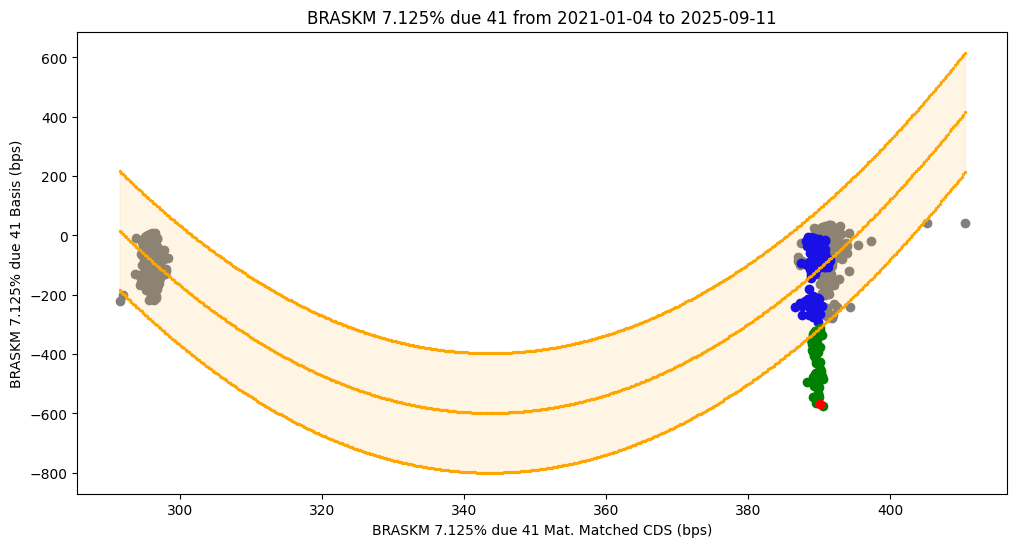

par scatter generated for BRASKM of fam EM


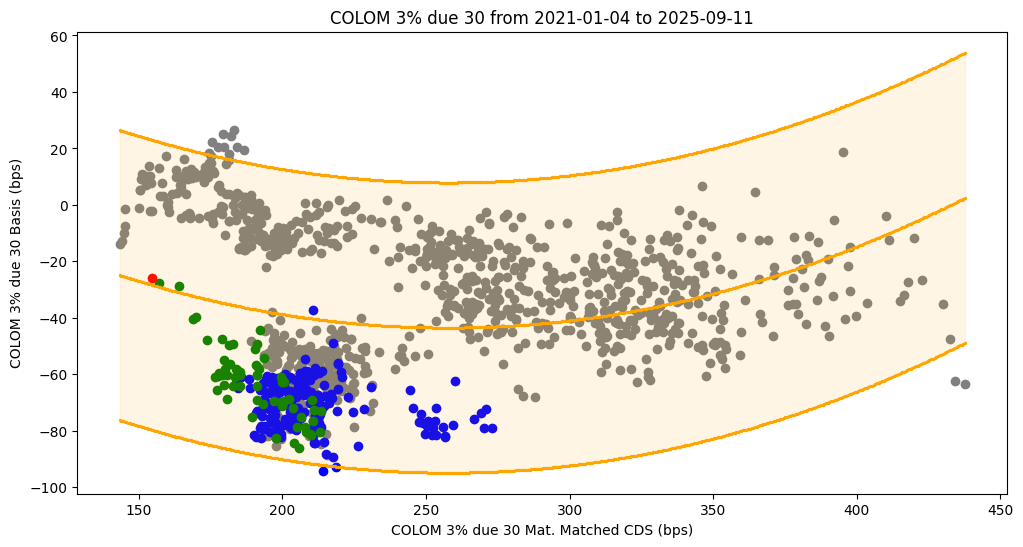

par scatter generated for COLOM of fam EM


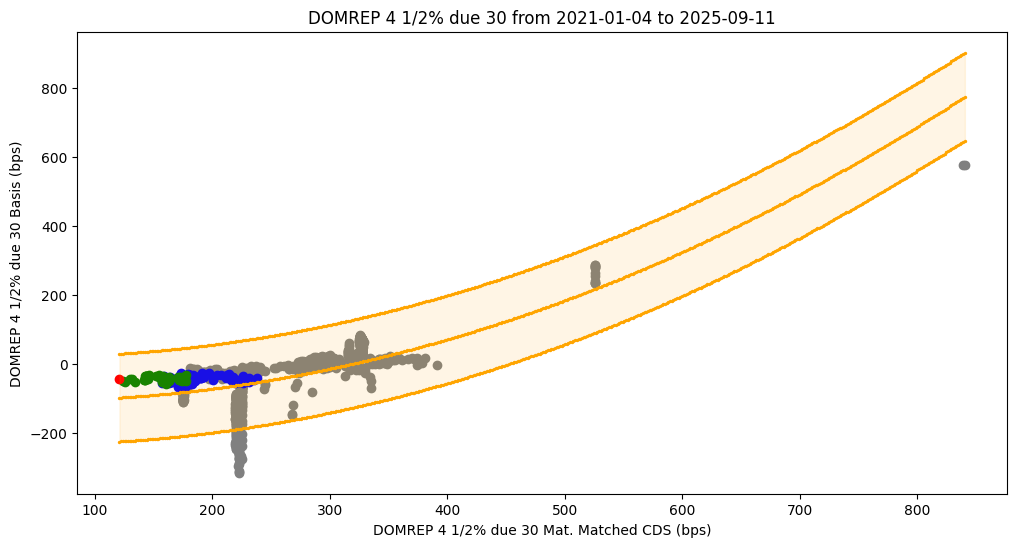

par scatter generated for DOMREP of fam EM


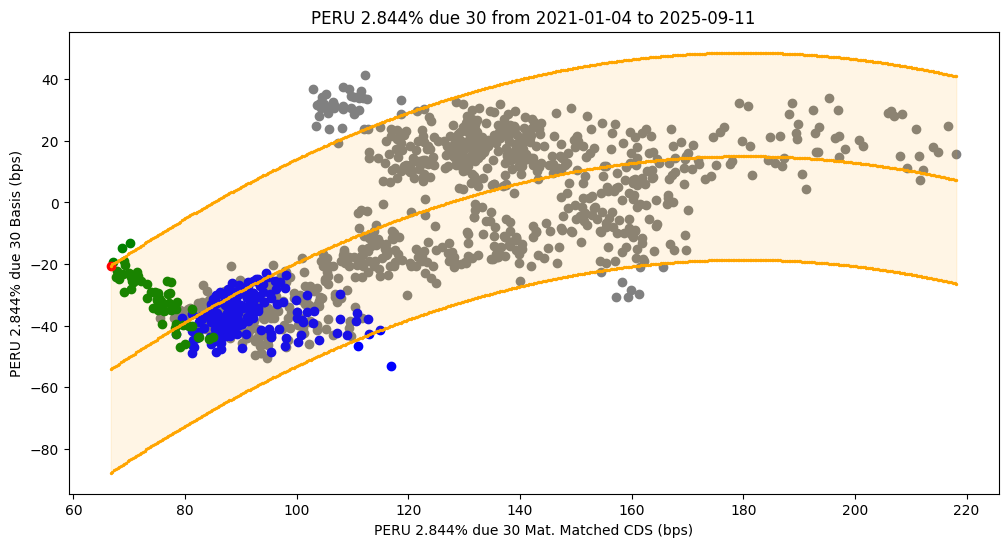

par scatter generated for PERU of fam EM


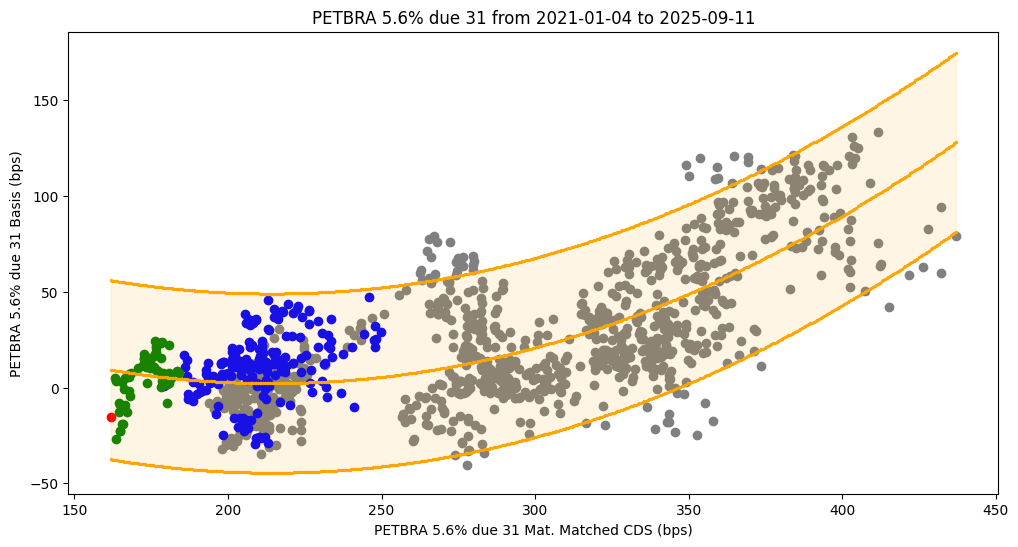

par scatter generated for PETBRA of fam EM


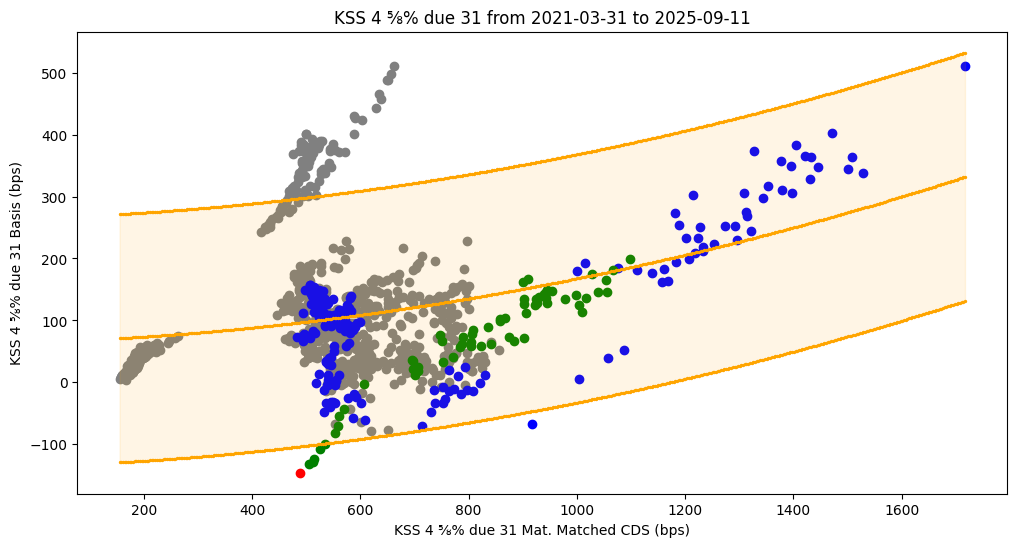

par scatter generated for KSS of fam HY


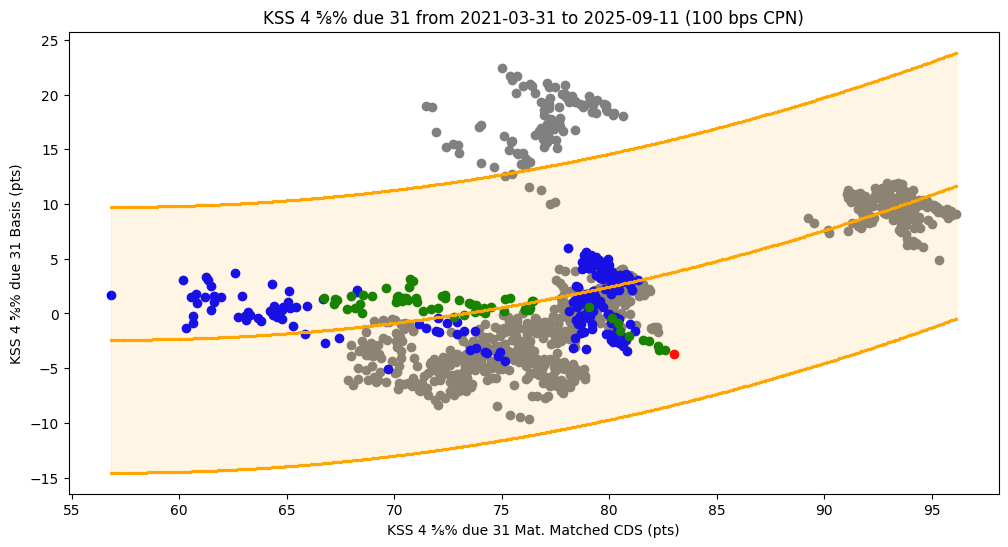

scatter generated for KSS of fam HY for 100


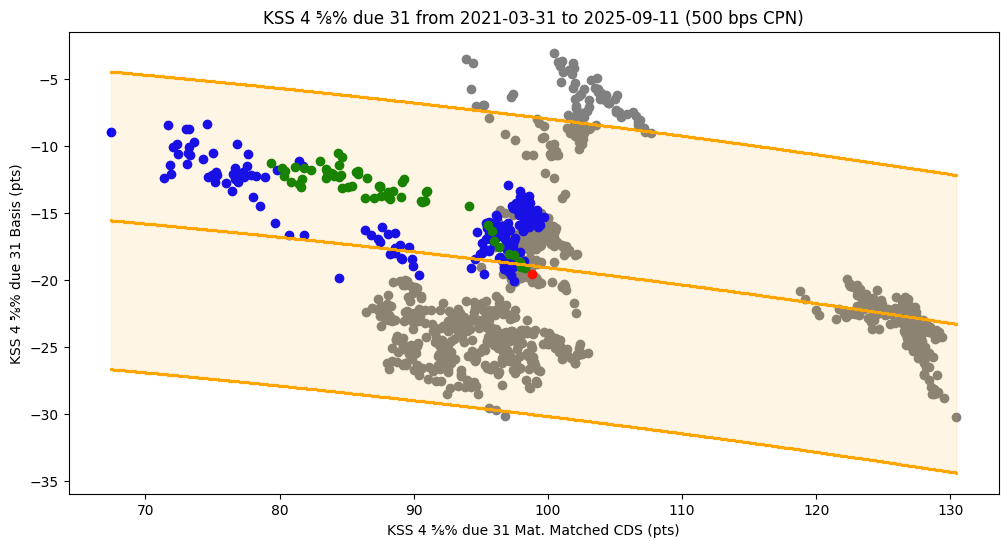

scatter generated for KSS of fam HY for 500


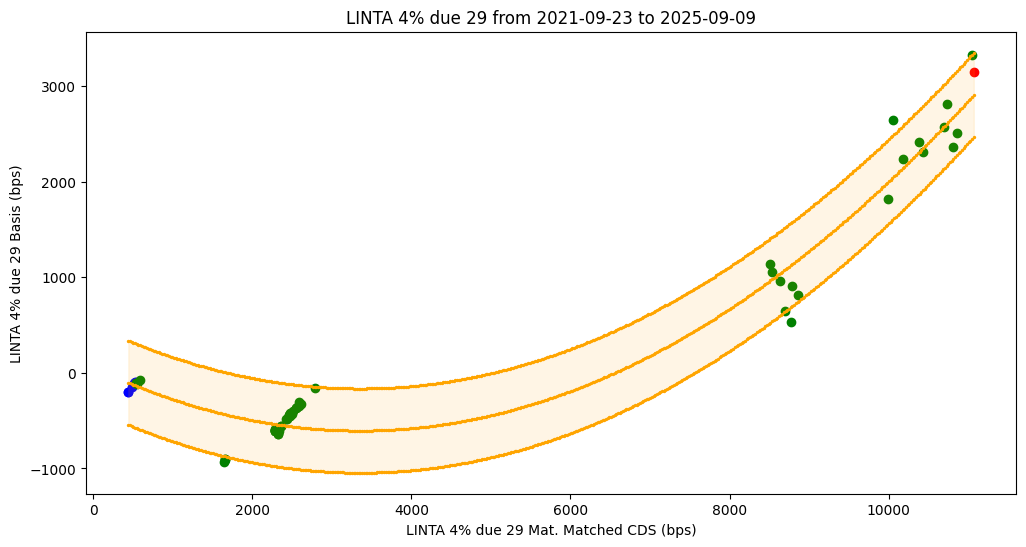

par scatter generated for LINTA of fam HY


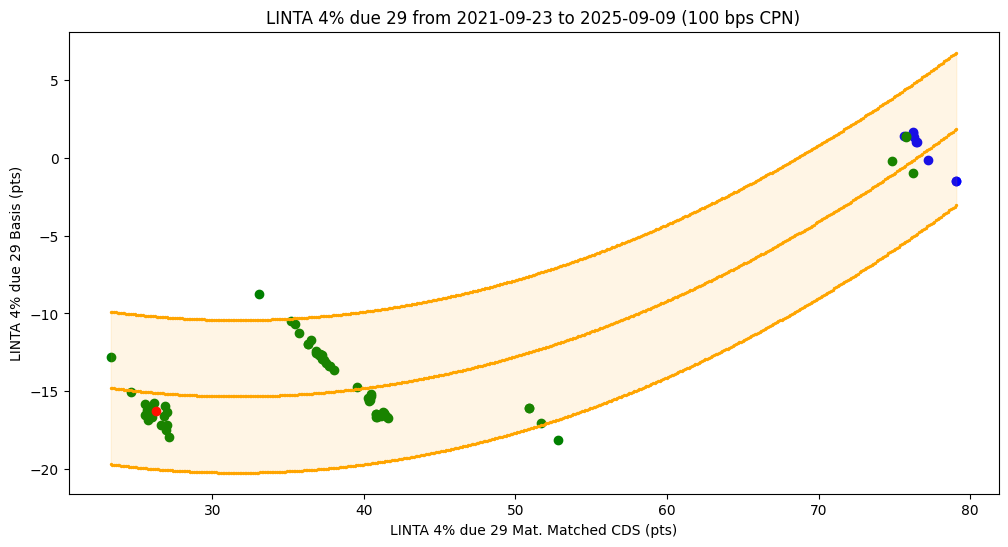

scatter generated for LINTA of fam HY for 100


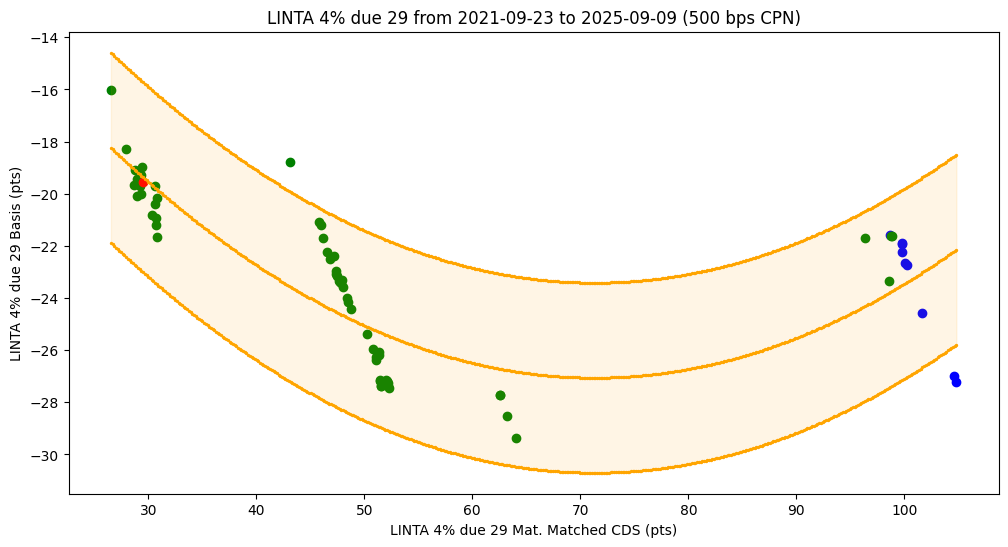

scatter generated for LINTA of fam HY for 500


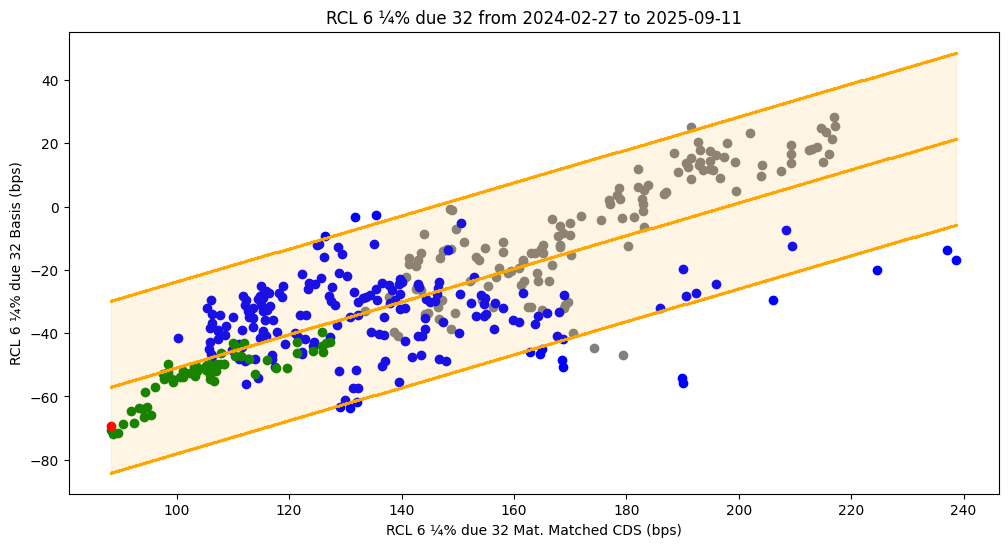

par scatter generated for RCL of fam HY


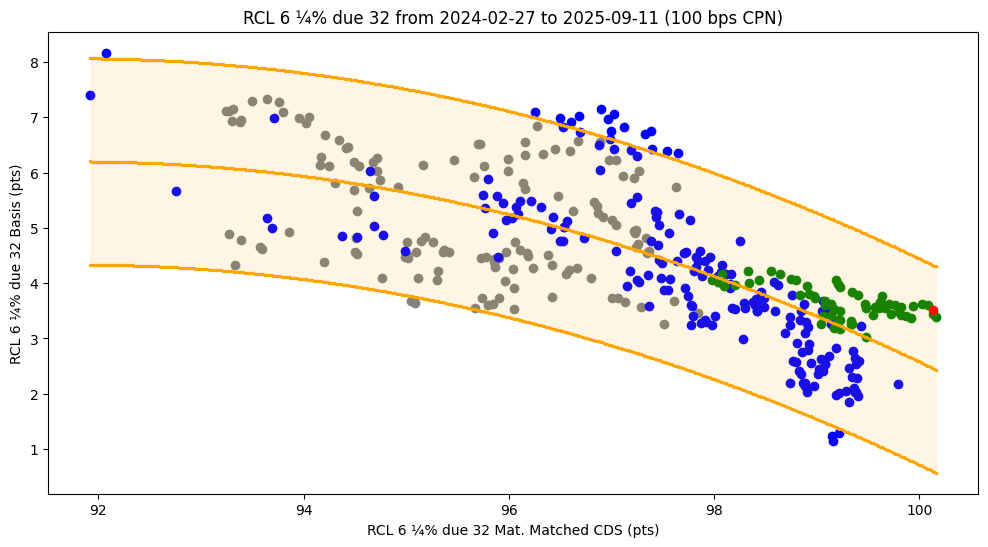

scatter generated for RCL of fam HY for 100


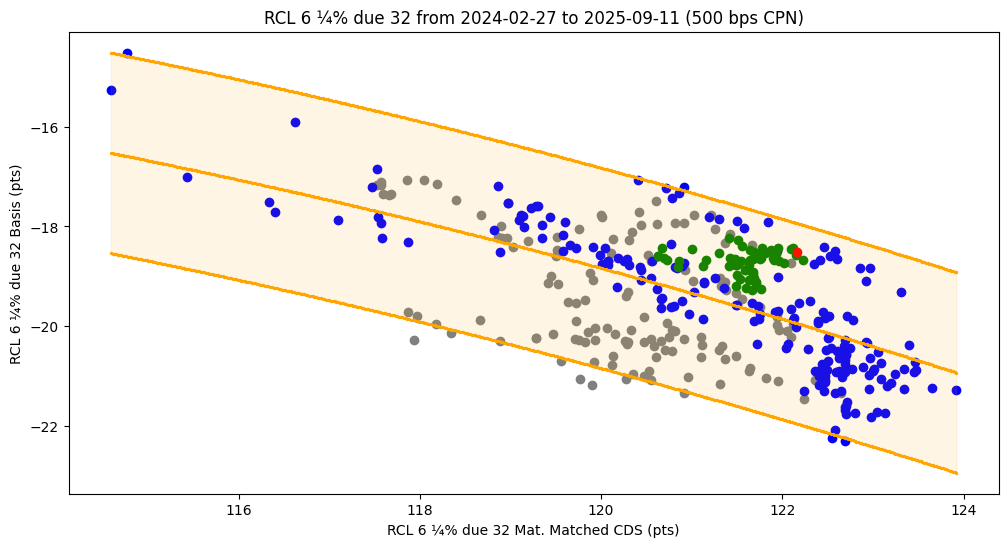

scatter generated for RCL of fam HY for 500


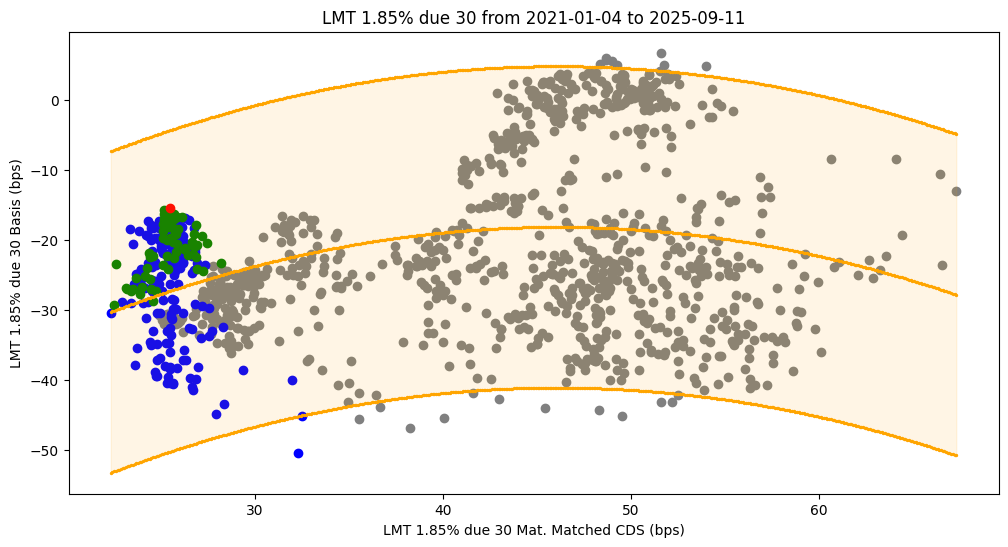

par scatter generated for LMT of fam IG


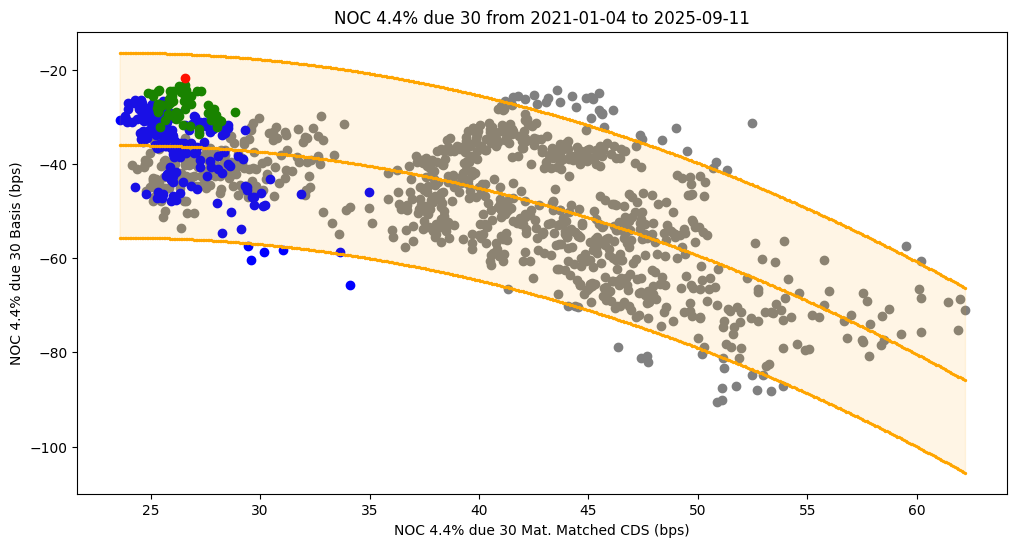

par scatter generated for NOC of fam IG


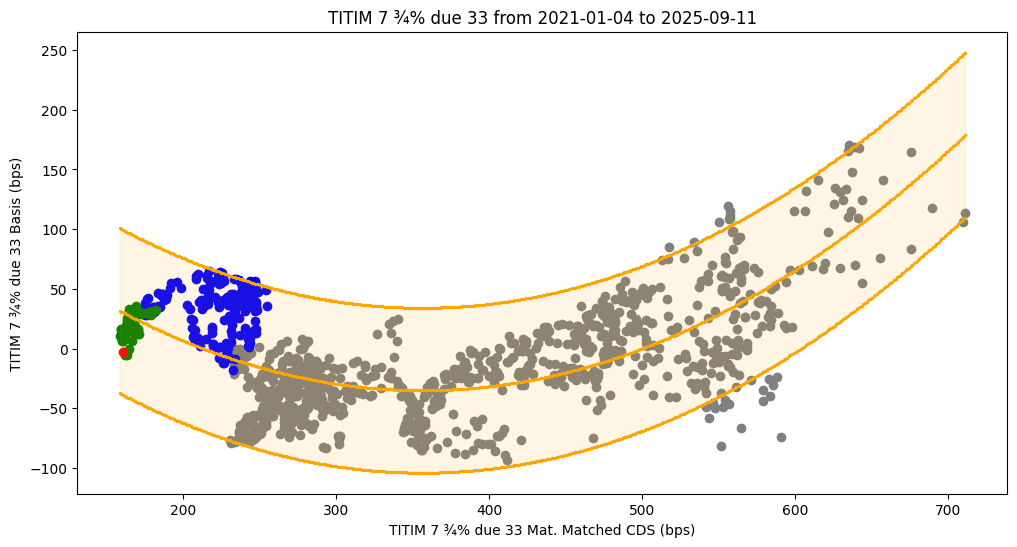

par scatter generated for TITIM of fam EUR_HY


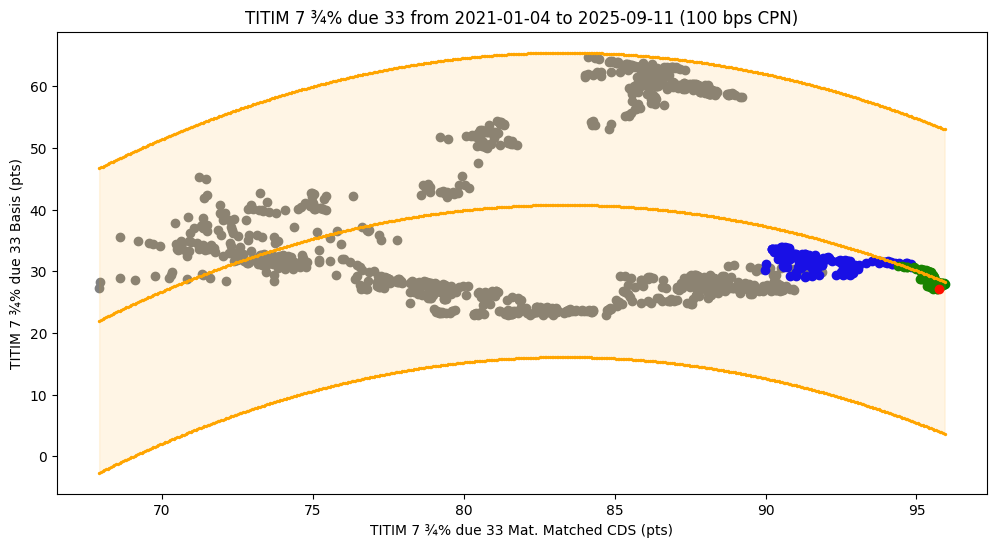

scatter generated for TITIM of fam EUR_HY for 100


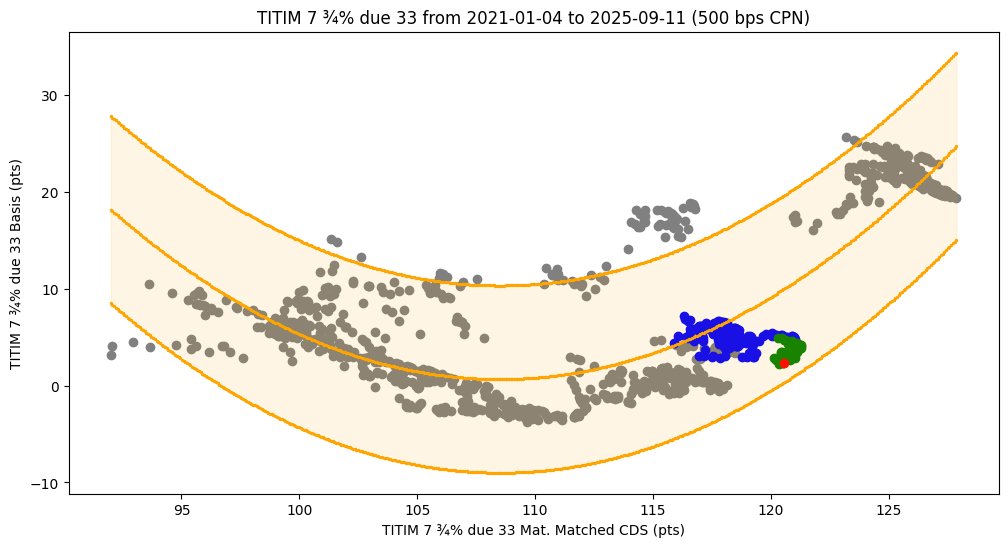

scatter generated for TITIM of fam EUR_HY for 500


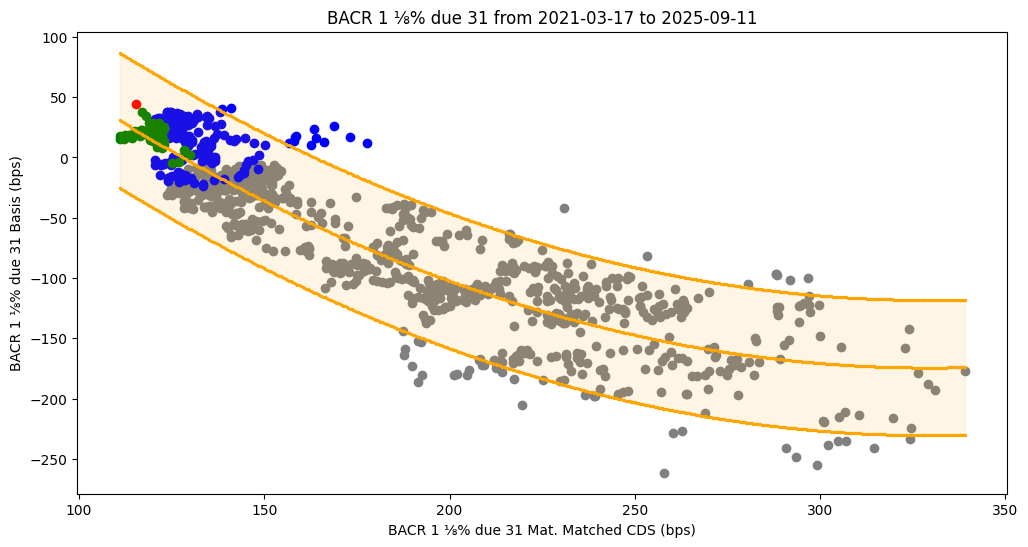

par scatter generated for BACR of fam SNRFIN


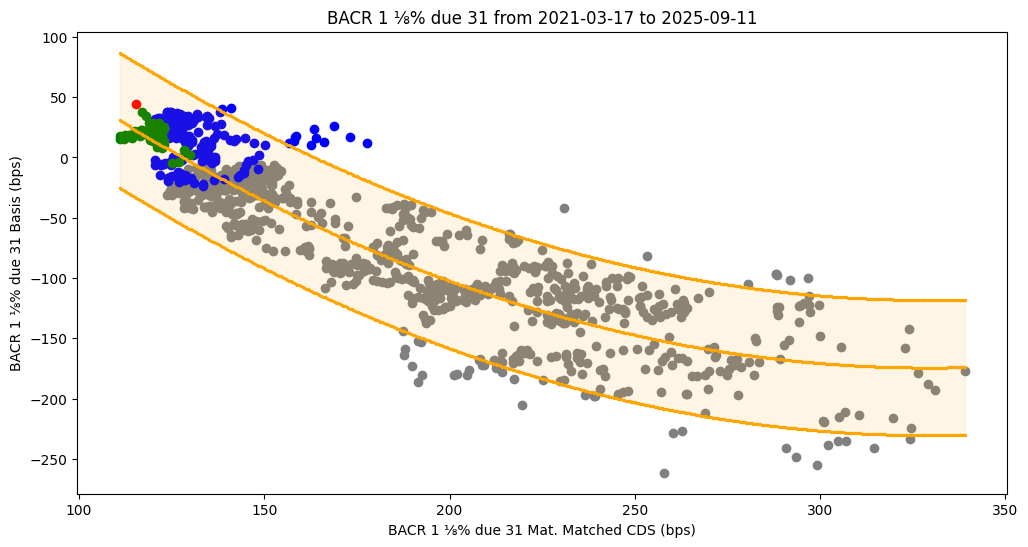

par scatter generated for BACR of fam SUBFIN


In [16]:
for fam in ["EM","HY","IG","EUR_HY", 'EUR_IG', 'SNRFIN', 'SUBFIN']:
    i=1
    x = plot_names[plot_names["Family"]==fam].copy()
    if len(x)>0:
        for item in x.index:
            gen_plots(item, all_bonds, fam, i)
            print(f"par scatter generated for {item} of fam {fam}")
            i += 1
            if fam == "HY" or fam == "EUR_HY":
                gen_plots(item, uf100_scatter, fam, i, True, "100")
                print(f"scatter generated for {item} of fam {fam} for 100")
                i += 1
                gen_plots(item, uf500_scatter, fam, i, True, "500")
                print(f"scatter generated for {item} of fam {fam} for 500")
                i += 1

In [17]:
import os
import win32com.client
import glob
import pandas as pd
import dataframe_image as dfi
from io import BytesIO
import tempfile

html_body = "<html><body>"

outlook = win32com.client.Dispatch("Outlook.Application")
mail = outlook.CreateItem(0)

folder_path = f'J:\\53A. HY Bonds Basis Email\\Email Plots'

for family in ["EM","HY","IG","EURHY", 'EURIG', 'SNRFIN', 'SUBFIN']:
    html_body += f'<h2 style="color:red;">{family}</h2>'
    png_files = glob.glob(os.path.join(folder_path, '*.png'))
    png_files = [item for item in png_files if item.rsplit("\\")[-1].split("_")[0]==family]
    png_files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].rsplit("_")[-1]))
    for png_file in png_files:
        raw_name = os.path.splitext(os.path.basename(png_file))[0]
        image_cid = raw_name.replace(" ", "_")
        attachment = mail.Attachments.Add(Source=png_file)
        attachment.PropertyAccessor.SetProperty("http://schemas.microsoft.com/mapi/proptag/0x3712001F", image_cid)
        html_body += f'<img src="cid:{image_cid}"><br><br><br>'

folder_path = f'J:\\53A. HY Bonds Basis Email\\Email Plots\\Scatter Plots2'

for family in ["EM","HY","IG","EURHY", 'EURIG', 'SNRFIN', 'SUBFIN']:
    
    png_files = glob.glob(os.path.join(folder_path, '*.png'))
    png_files = [item for item in png_files if ((item.rsplit("\\")[-1].\
        split("_",1)[1].rsplit("_",1)[0]==family) and (item.rsplit("\\")[-1].split("_")[0]==str(datetime.now().date())))]
    png_files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].rsplit("_")[-1]))
    if len(png_files) > 0:
        html_body += f'<h2 style="color:red;">{family} Basis Scatter Plots</h2>'
        for png_file in png_files:
            raw_name = os.path.splitext(os.path.basename(png_file))[0]
            image_cid = raw_name.replace(" ", "_")
            attachment = mail.Attachments.Add(Source=png_file)
            attachment.PropertyAccessor.SetProperty("http://schemas.microsoft.com/mapi/proptag/0x3712001F", image_cid)
            html_body += f'<img src="cid:{image_cid}"><br><br><br>'
    
html_body += '</body></html>'

mail.HTMLBody = html_body
mail.Subject = f'Median Basis ZScores (auto)'
mail.CC = 'vasu.sharma@iiicm.com'
if email_both:
    mail.To = 'spyros.michas@iiicm.com'
mail.Send()

print("Sent")

Sent
